In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Train the ML model
from utils import sample_files, encoder_files_to_tensors
from utils import plot_loss, load_encoder_data
from models import EncoderSingle

import time
import glob
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl



In [3]:
num_Turns_Case = 50+1
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# Initialize parameters
data_dir = '/eos/user/k/kiliakis/tomo_data/datasets'
# data_dir = './tomo_data/datasets'
# timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
timestamp = 'VrfSPS_hyper_params'
print('Using timestamp: ', timestamp)



Using timestamp:  VrfSPS_hyper_params


In [4]:
# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
# weights_dir = os.path.join(trial_dir, 'weights')
# plots_dir = os.path.join(trial_dir, 'plots')
# logs_dir = os.path.join(trial_dir, 'logs')

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')
assert os.path.exists(TRAINING_PATH)
assert os.path.exists(VALIDATION_PATH)

# create the directory to store the results
os.makedirs(trial_dir, exist_ok=True)
# os.makedirs(weights_dir, exist_ok=False)
# os.makedirs(plots_dir, exist_ok=False)
# os.makedirs(logs_dir, exist_ok=False)

# Initialize GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
device_to_use = 0

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpus[device_to_use], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[device_to_use],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12*1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(
            logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('No GPU available, using the CPU')


1 Physical GPUs, 1 Logical GPUs


In [5]:
IMG_OUTPUT_SIZE = 128
BATCH_SIZE = 32  # 8
input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)

# Train specific
train_cfg = {
    'epochs': 10,
    'dense_layers': [16],
    'filters': [8],
    'cropping': [0, 0],
    'kernel_size': 7,
    'strides': [2, 2],
    'activation': 'relu',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.1,
    'loss': 'mse',
    'lr': 1e-3,
    'dataset%': 1,
    'normalization': 'minmax',
    'loss_weights': [6],
    'batch_size': 32
}

In [6]:
start_t = time.time()
# Create the datasets
# 1. Randomly select the training data
file_names = sample_files(TRAINING_PATH, train_cfg['dataset%'], keep_every=num_Turns_Case)
print('Number of Training files: ', len(file_names))

x_train, y_train = encoder_files_to_tensors(
    file_names, normalization=train_cfg['normalization'])

# Repeat for validation data
file_names = sample_files(
    VALIDATION_PATH, train_cfg['dataset%'], keep_every=num_Turns_Case)
print('Number of Validation files: ', len(file_names))

x_valid, y_valid = encoder_files_to_tensors(
    file_names, normalization=train_cfg['normalization'])

end_t = time.time()
print(
    f'\n---- Input files have been read, elapsed: {end_t - start_t} ----\n')


Number of Training files:  6646
Number of Validation files:  1178

---- Input files have been read, elapsed: 337.7385802268982 ----



In [ ]:
%matplotlib inline
# plot some of the outputs

nrows = 3
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    ax.set_title(f'{title}')


In [9]:
print(timestamp)
print(trial_dir)

VrfSPS_hyper_params
./trials/VrfSPS_hyper_params


In [24]:
from itertools import product
IMG_OUTPUT_SIZE = 128
BATCH_SIZE = 32  # 8
input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)

# Train specific
train_cfg = {
    'epochs': 10,
    'dense_layers': [16],
    'filters': [8],
    'cropping': [0, 0],
    'kernel_size': 7,
    'strides': [2, 2],
    'activation': 'relu',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.1,
    'loss': 'mse',
    'lr': 1e-3,
    'dataset%': 1,
    'normalization': 'minmax',
    'loss_weights': [5],
    'batch_size': 32
}

model_cfg = {
    'mu': {
        'epochs': 15,
        'cropping': [6, 6],
        'filters': [8, 16, 32],
        'kernel_size': [13, 7, 3],
        'strides': [2, 2],
        'dense_layers': [1024, 256, 32],
        'activation': 'relu',
        'pooling': None,
        'dropout': 0.0,
        'lr': 1e-3,
        'normalization': 'minmax',
        'batch_size': 32
    },
}

param_space = {
    'cropping': [[0, 0]],
    'kernel_size': [[3, 3, 3], [5, 5, 3], [5, 5, 5], [7, 5, 3], [7, 7, 7], [13, 7, 3]],
    'filters': [[2, 4, 8], [4, 8, 16], [8, 16, 32], [4, 4, 8], [8, 8, 16]],
    'dense_layers': [[1024, 512, 32], [1024, 512, 64], [1024, 512, 256],
                     [1024, 256, 32], [1024, 256, 64], [1024, 256, 128],
                     [2048, 1024, 64], [2048, 1024, 128], [2048, 1024, 256],
                     [2048, 512, 32], [2048, 512, 64], [2048, 512, 128]]
}


def train_test_model(var_name, x_train, y_train, x_valid, y_valid, hparamdir, hparams):
    cfg = train_cfg.copy()
    cfg.update(model_cfg.get(var_name, {}))
    cfg.update(hparams)
    
    model = EncoderSingle(input_shape=input_shape,
                         output_name=var_name,
                         **cfg)
    weights_dir = os.path.join(hparamdir, 'weights')
    # callbacks, save the best model, and early stop if no improvement in val_loss
#     stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                patience=10, restore_best_weights=True)
#     save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder_{var_name}.h5'),
#                                                 monitor='val_loss', save_best_only=True)
    callbacks = [
#         save_best,
        keras.callbacks.TensorBoard(hparamdir,
#                                             histogram_freq=1,
#                                             write_graph=True,
#                                             write_images=True,
                                            update_freq='epoch',
#                                             embeddings_freq=1
                                            ),
#                  hp.KerasCallback(logdir, hparams)
                ]
    start_t = time.time()
    history = model.model.fit(
        x=x_train, y=y_train, 
        epochs=cfg['epochs'],
        validation_data=(x_valid, y_valid),
        callbacks=callbacks, 
        batch_size=cfg['batch_size'],
        verbose=0)
    total_t = time.time() - start_t
    val_loss = model.model.evaluate(x_valid, y_valid)
    
    # save file with experiment configuration
    config_dict = {}
    config_dict['encoder'] = cfg.copy()
    config_dict['encoder'].update({
        'min_train_loss': float(np.min(history.history['loss'])),
        'min_valid_loss': float(np.min(history.history['val_loss'])),
        'total_train_time': total_t,
        'used_gpus': len(gpus)
    })

    # save config_dict
    with open(os.path.join(hparamdir, 'encoder-summary.yml'), 'w') as configfile:
        yaml.dump(config_dict, configfile, default_flow_style=False)
    
    return history.history, val_loss

var_name = 'mu'
train = tf.gather(y_train, var_names.index(var_name), axis=1)
valid = tf.gather(y_valid, var_names.index(var_name), axis=1)

# runs = os.listdir(trial_dir)
# runs = [int(r.split('-')[-1]) for r in runs]
session_num = 0
# historyMulti = []
keys, values = zip(*param_space.items())
total_runs = np.prod([len(v) for v in param_space.values()])

overall_dict = {}
for bundle in product(*values):
    hparams = dict(zip(keys, bundle))
    run_name = f"run-{session_num}"
    print(f'--- Starting trial: {run_name}/{total_runs}')
#     print({h.name: hparams[h] for h in hparams})
    print(hparams)
    start_t = time.time()
    history, loss = train_test_model(var_name, x_train, train, x_valid, valid, os.path.join(trial_dir, run_name), hparams)
    total_time = time.time() - start_t
    train_loss = np.min(history["loss"])
    valid_loss = np.min(history["val_loss"])
    overall_dict[run_name] = {'time': total_time, 'train': train_loss, 'valid': valid_loss, 'history': history}
    overall_dict[run_name].update(hparams)
    print(f'---- Training complete, epochs: {len(history["loss"])}, train loss {np.min(history["loss"]):.2e}, valid loss {np.min(history["val_loss"]):.2e}, total time {total_time} ----')
    
#     historyMulti.append(history)
    session_num += 1


--- Starting trial: run-0/360
{'cropping': [0, 0], 'kernel_size': [3, 3, 3], 'filters': [2, 4, 8], 'dense_layers': [1024, 512, 32]}
37/37 [==============================] - 0s 4ms/step - loss: 0.0118 - mae: 0.0806
---- Training complete, epochs: 15, train loss 7.87e-03, valid loss 9.60e-03, total time 22.483449459075928 ----
--- Starting trial: run-1/360
{'cropping': [0, 0], 'kernel_size': [3, 3, 3], 'filters': [2, 4, 8], 'dense_layers': [1024, 512, 64]}
37/37 [==============================] - 0s 4ms/step - loss: 0.0077 - mae: 0.0625
---- Training complete, epochs: 15, train loss 5.97e-03, valid loss 7.73e-03, total time 22.151466131210327 ----
--- Starting trial: run-2/360
{'cropping': [0, 0], 'kernel_size': [3, 3, 3], 'filters': [2, 4, 8], 'dense_layers': [1024, 512, 256]}
37/37 [==============================] - 0s 4ms/step - loss: 0.0339 - mae: 0.1399
---- Training complete, epochs: 15, train loss 2.13e-02, valid loss 3.39e-02, total time 22.365214109420776 ----
--- Starting trial

In [16]:
import pickle
import os
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
os.makedirs('hparam_dicts', exist_ok=True)
fname = f'hparam_dicts/{var_name}_{timestamp}.pkl'
with open(fname, 'wb') as handle:
    pickle.dump(overall_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# load the data from the hparam dict
all_data = {}
idx = 0
for fname in os.listdir('hparam_dicts'):
    if ('.pkl' not in fname) or (var_name not in fname):
        continue
    with open('hparam_dicts/' + fname, 'rb') as handle:
        temp_d = pickle.load(handle)
    for k, v in temp_d.items():
        all_data[idx] = v
        idx+=1
print(f'All data have been restored, datapoints: {len(all_data)}')

All data have been restored, datapoints: 720


In [10]:
# best_params = [(k, v['valid']) for k, v in overall_dict.items()]
# best_params = sorted(best_params, key=lambda a: a[1])
# for k, valid in best_params:
#     print(f'{valid:.3e}:', overall_dict[k]['hparams'])

KeyError: 'hparams'

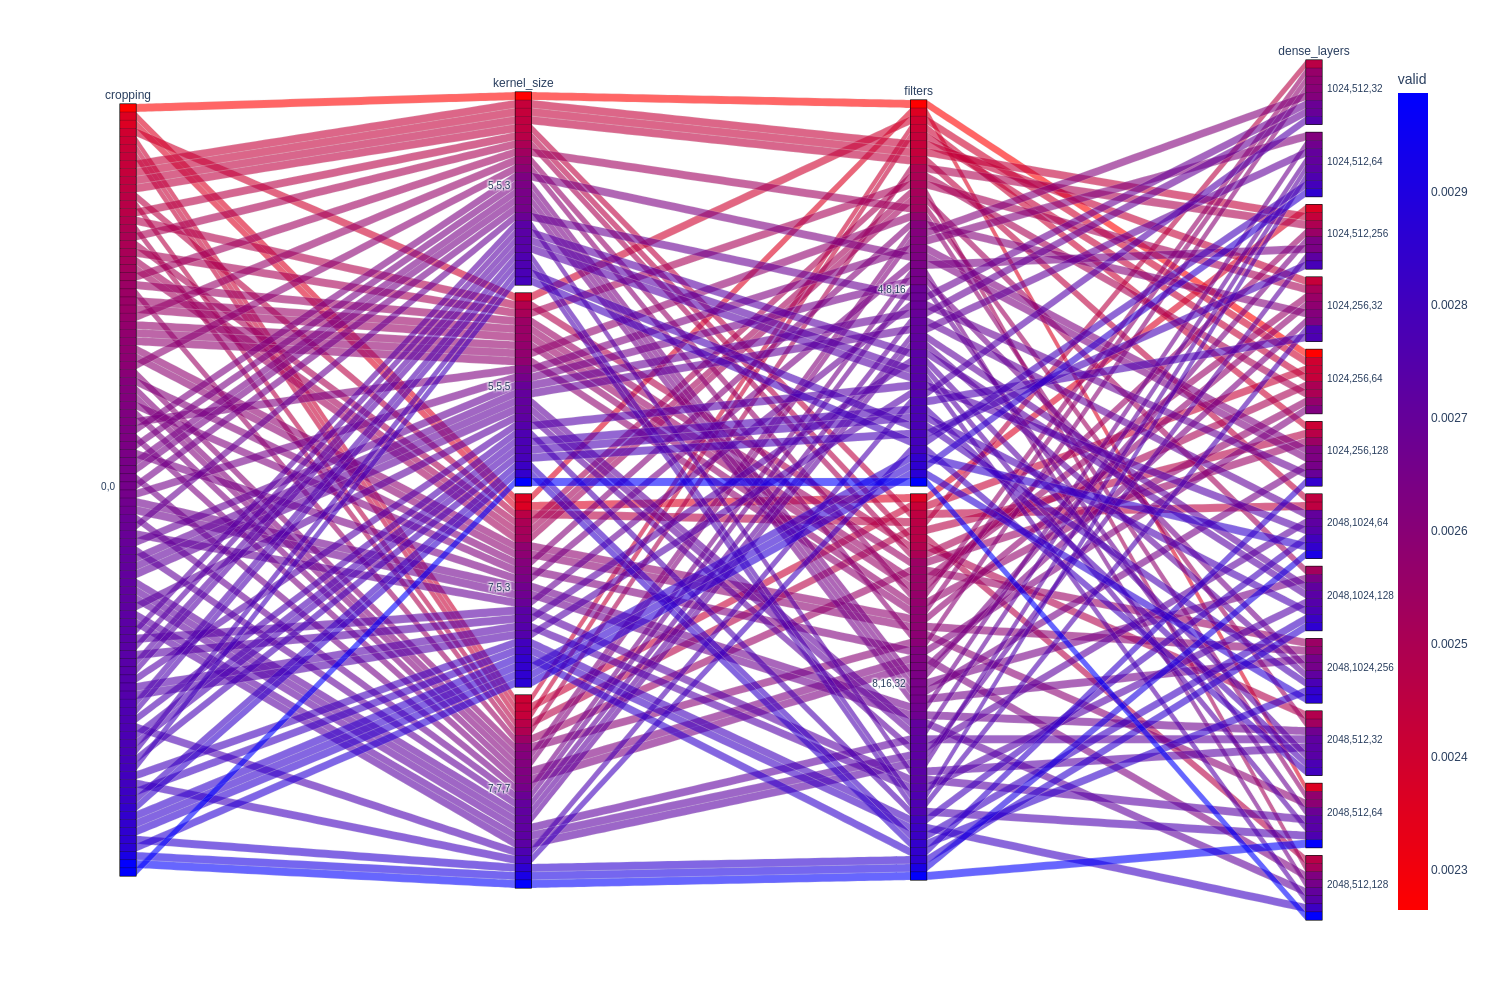

In [23]:
import pandas as pd
import plotly.express as px

def filter_dict(data, filters):
    keep_data = {}
    for k, v in data.items():
        to_keep=True
        for f, fv in filters.items():
            to_keep &= v[f] in fv
        if to_keep:
            keep_data[k] = v
    return keep_data

filters = {'cropping': [[0,0]],
           'kernel_size': [[5, 5, 3], [5, 5, 5], [7, 5, 3], [7, 7, 7]],
           'filters': [[4, 8, 16], [8, 16, 32]]
          }

filtered_data = filter_dict(all_data, filters)


hdf = pd.DataFrame.from_dict(filtered_data, orient='index')
hdf.drop(columns=['time', 'train', 'history'], inplace=True)




fig = px.parallel_categories(hdf,
                             color='valid',
                             dimensions=list(param_space.keys()),
                             color_continuous_scale=px.colors.sequential.Bluered_r,
                             color_continuous_midpoint=None,
                            height=1000)
fig.show()

In [ ]:
# from itertools import product
# import ray
# from ray import air, tune
# from ray.air import session
# from ray.tune.schedulers import AsyncHyperBandScheduler
# from ray.tune.integration.keras import TuneReportCallback
# # import keras_tuner as kt
# # from hyperopt import hp
# from functools import partial

# IMG_OUTPUT_SIZE = 128
# BATCH_SIZE = 32  # 8
# input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)

# # Train specific
# train_cfg = {
#     'epochs': 10,
#     'dense_layers': [16],
#     'filters': [8],
#     'cropping': [0, 0],
#     'kernel_size': 7,
#     'strides': [2, 2],
#     'activation': 'relu',
#     'pooling': None,
#     'pooling_size': [0, 0],
#     'pooling_strides': [1, 1],
#     'pooling_padding': 'valid',
#     'dropout': 0.1,
#     'loss': 'mse',
#     'lr': 1e-3,
#     'dataset%': 1,
#     'normalization': 'minmax',
#     'loss_weights': [6],
#     'batch_size': 32
# }

# model_cfg = {
#     # best VrfSPS config --> 2.78e-03 val loss
#     'VrfSPS': {
#         'epochs': 100,
#         'cropping': [(6, 6), (6, 64)],
#         'filters': [4, 8, 16],
#         'kernel_size': [(13, 3), (7, 3), 3],
#         'strides': [2, 2],
#         'dense_layers': [1024, 512, 32],
#         'activation': 'relu',
#         'loss': 'mse',
#         'pooling': None,
#         'dropout': 0.0,
#         'lr': 1e-3,
#         'normalization': 'minmax',
#         'batch_size': 32
#     },
# }

# param_space = {
#     'dense_layers': tune.choice([[32], [64], [128], [256], [512], [1024]])
# }

# var_name = 'VrfSPS'
# train = tf.gather(y_train, var_names.index(var_name), axis=1)
# valid = tf.gather(y_valid, var_names.index(var_name), axis=1)

# def train_test_model(var_name, x_train, y_train, x_valid, y_valid, hparams):
#     cfg = train_cfg.copy()
#     cfg.update(model_cfg.get(var_name, {}))
#     cfg.update(hparams)
#     model = EncoderSingle(input_shape=input_shape,
#                          output_name=var_name,
#                          **cfg)
    
#     # callbacks, save the best model, and early stop if no improvement in val_loss
# #     stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
# #                                                patience=10, restore_best_weights=True)
#     save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder_{var_name}.h5'),
#                                                 monitor='val_loss', save_best_only=True)
#     callbacks = [save_best,
# #                  keras.callbacks.TensorBoard(logdir),
# #                  hp.KerasCallback(logdir, hparams)
#                 ]
#     history = model.model.fit(
#         x=x_train, y=y_train, 
#         epochs=cfg['epochs'],
#         validation_data=(x_valid, y_valid),
#         callbacks=callbacks, 
#         batch_size=cfg['batch_size'],
#         verbose=0)
    
#     val_loss = model.model.evaluate(x_valid, y_valid)
#     session.report({"score": val_loss})
# #     return val_loss


# tuner = tune.Tuner(
#     partial(train_test_model, 'VrfSPS', x_train, train, x_valid, valid),
#     param_space=param_space,
#     tune_config=tune.TuneConfig(metric="score", mode='min', num_samples=6)
# )
# results = tuner.fit()
# print("Best hyperparameters found were: ", results.get_best_result().config)

In [ ]:
%matplotlib inline
train_loss_l = []
valid_loss_l = []
for k, v in historyMulti.items():
    if 'val' in k:
        valid_loss_l.append(v)
    else:
        train_loss_l.append(v)

train_loss_l = np.mean(train_loss_l, axis=0)
valid_loss_l = np.mean(valid_loss_l, axis=0)
# print(train_loss_l)
plot_loss({'training': train_loss_l, 'validation': valid_loss_l},
          title='Encoder Train/Validation Loss')

plot_loss(historyMulti, title='Encoder loss per output')

# print(historyMulti)


In [ ]:
# save file with experiment configuration
config_dict = {}
config_dict['encoder'] = train_cfg.copy()
config_dict['encoder'].update({
    'min_train_loss': float(np.min(train_loss_l)),
    'min_valid_loss': float(np.min(valid_loss_l)),
    'total_train_time': total_time,
    'used_gpus': len(gpus)
})

# save config_dict
with open(os.path.join(trial_dir, 'encoder-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)
